# XGBoost Classifier

By Alberto Valdés 

**Mail 1:** anvaldes@uc.cl 

**Mail 2:** alberto.valdes.gonzalez.96@gmail.com

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import time
import scipy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from matplotlib import image as mpimg

In [3]:
def display_img(name, a, b):
    plt.figure(figsize = (a, b))
    image = mpimg.imread(name)
    plt.imshow(image)
    plt.axis('off')
    plt.show()

XGBoost is a powerful approach for building supervised regression models. The validity of this statement can be inferred by knowing about its (XGBoost) objective function and base learners. The objective function contains loss function and a regularization term. It tells about the difference between actual values and predicted values, i.e how far the model results are from the real values. The most common loss functions in XGBoost for regression problems is reg:linear, and that for binary classification is reg:logistics. 

XGBoost has a **Level-Wise Growth** and LightGBM has a **Leaf-Wise Growth**

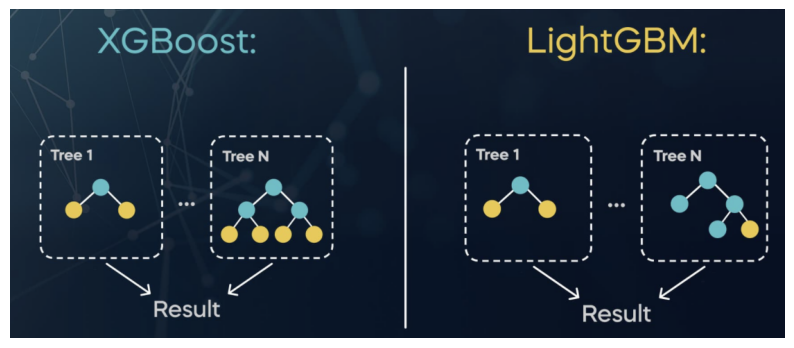

In [4]:
display_img('XGBoost_vs_LightGBM.png', 10, 10)

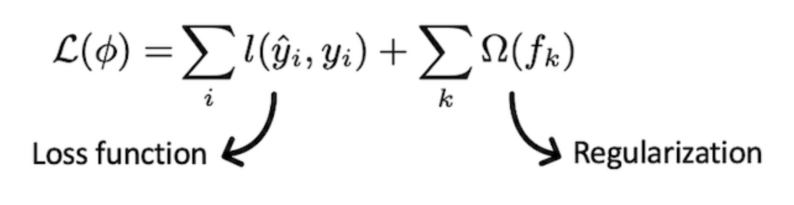

In [5]:
display_img('Formula.png', 10, 10)

**The regularization is to avoid overfitting.**

$ \Omega(f) = \gamma \cdot T + \cfrac{1}{2} \cdot \lambda \cdot || w ||^2  $

where $T$ is the number of leaves and $ w $ is the learning-weights.

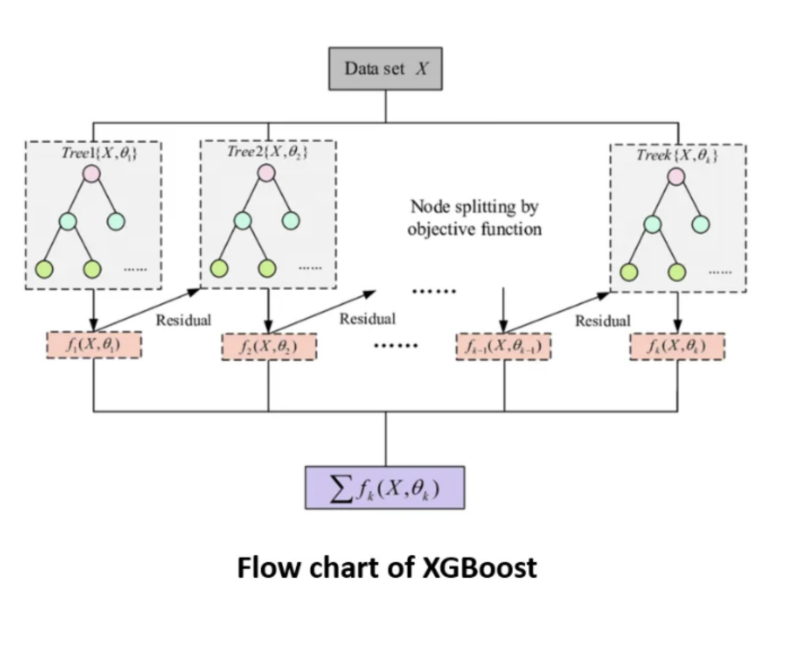

In [6]:
display_img('XGBoost.png', 10, 10)

**Considerations:**

- The trees aren't sensitive to scaling.
- This algorithm brings calibrator and balancetor.

In [7]:
start = time.time()

# 1. Preprocessing

### i. Read Dataframe

In [8]:
df = pd.read_csv('credit_risk.csv')

In [9]:
cat_str = ['person_home_ownership', 'loan_intent']
cat_oh = ['cb_person_default_on_file', 'loan_grade']

num_mean = ['person_age', 'person_income', 'loan_percent_income']

num_mean_nan = ['loan_int_rate', 'person_emp_length']
num_zero_nan = ['loan_amnt']

X_cols = cat_str + cat_oh + num_mean + num_mean_nan + num_zero_nan

label = 'loan_status'

### ii. Drop 'y' NaNs

In [10]:
df = df[df[label].notna()]

### iii. Split

In [11]:
from sklearn.model_selection import train_test_split

In [12]:
features_dict = {
    'cat_str': cat_str,
    'cat_oh': cat_oh,
    'num_mean': num_mean,
    'num_mean_nan': num_mean_nan,
    'num_zero_nan': num_zero_nan
}

In [13]:
X = df[X_cols].copy()
y = df[label].copy()

In [14]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.40, random_state = 10)
X_val, X_test, y_val, y_test = train_test_split(X_val, y_val, test_size = 0.50, random_state = 10)

### iv. Fit preprocess

In [15]:
from preprocessing import *

In [16]:
transformers_pre = get_fit_transfomers(features_dict, X_train, y_train)

In [17]:
y_train = y_train.reset_index()
y_train = y_train.drop(columns = ['index'])

y_val = y_val.reset_index()
y_val = y_val.drop(columns = ['index'])

y_test = y_test.reset_index()
y_test = y_test.drop(columns = ['index'])

In [18]:
X_train = transform_datasets(transformers_pre, features_dict, X_train)

X_val = transform_datasets(transformers_pre, features_dict, X_val)

X_test = transform_datasets(transformers_pre, features_dict, X_test)

### v. Train model (with Fine Tunning)

In [19]:
from sklearn.metrics import f1_score

In [20]:
!pip install -q xgboost

In [21]:
from xgboost import XGBClassifier

In [22]:
N_est_max = 100
M_depth_max = 10

In [23]:
N_est = [i for i in range(1, N_est_max + 1)]
M_depth = [j for j in range(1, M_depth_max + 1)]

In [24]:
threshold = round(y_val['loan_status'].mean(), 2)

In [25]:
all_f1_train = []
all_f1_val = []
all_params = []

for n_est in N_est:

    print('N estimators: ', n_est)

    for m_depth in M_depth:

        clf = XGBClassifier(n_estimators = n_est, max_depth = m_depth, learning_rate = 0.2, random_state = 0)

        clf = clf.fit(X_train, y_train)

        y_train_pred_prob = clf.predict_proba(X_train)[:, 1]
        y_val_pred_prob = clf.predict_proba(X_val)[:, 1]

        y_train_pred = (y_train_pred_prob >= threshold)*1
        y_val_pred = (y_val_pred_prob >= threshold)*1

        f1_train = f1_score(y_train, y_train_pred)
        f1_val = f1_score(y_val, y_val_pred)

        all_f1_train.append(f1_train)
        all_f1_val.append(f1_val)
        all_params.append([n_est, m_depth])
    
    print('-'*70)

all_f1_train = np.array(all_f1_train)
all_f1_val = np.array(all_f1_val)
all_params = np.array(all_params)

N estimators:  1
----------------------------------------------------------------------
N estimators:  2
----------------------------------------------------------------------
N estimators:  3
----------------------------------------------------------------------
N estimators:  4
----------------------------------------------------------------------
N estimators:  5
----------------------------------------------------------------------
N estimators:  6
----------------------------------------------------------------------
N estimators:  7
----------------------------------------------------------------------
N estimators:  8
----------------------------------------------------------------------
N estimators:  9
----------------------------------------------------------------------
N estimators:  10
----------------------------------------------------------------------
N estimators:  11
----------------------------------------------------------------------
N estimators:  12
------------

In [26]:
f1_train_opt = all_f1_train[all_f1_val == all_f1_val.max()][0]
f1_val_opt = all_f1_val[all_f1_val == all_f1_val.max()][0]
N_est_opt, M_depth_opt = all_params[all_f1_val == all_f1_val.max()][0]

In [27]:
print('F1 Train:', round(f1_train_opt*100, 2))
print('F1 Val:', round(f1_val_opt*100, 2))
print('N est opt:', N_est_opt)
print('M depth opt:', M_depth_opt)
print('Threshold:', threshold)

F1 Train: 94.34
F1 Val: 80.8
N est opt: 100
M depth opt: 8
Threshold: 0.22


### vi. Train definitive model

In [28]:
clf = XGBClassifier(n_estimators = N_est_opt, max_depth = M_depth_opt, learning_rate = 0.2, random_state = 0)

In [29]:
clf = clf.fit(X_train, y_train)

In [30]:
y_train_pred_prob = clf.predict_proba(X_train)[:, 1]
y_val_pred_prob = clf.predict_proba(X_val)[:, 1]
y_test_pred_prob = clf.predict_proba(X_test)[:, 1]

y_train_pred = (y_train_pred_prob >= threshold)*1
y_val_pred = (y_val_pred_prob >= threshold)*1
y_test_pred = (y_test_pred_prob >= threshold)*1

f1_train = f1_score(y_train, y_train_pred)
f1_val = f1_score(y_val, y_val_pred)
f1_test = f1_score(y_test, y_test_pred)

In [31]:
print('F1 Train:', round(f1_train*100, 2))
print('F1 Val:', round(f1_val*100, 2))
print('F1 Test:', round(f1_test*100, 2))

F1 Train: 94.34
F1 Val: 80.8
F1 Test: 81.31


### vii. Calibration

How the model have a calibrator, this step it's not necessary.

### viii. Report Calibration

In [32]:
from sklearn.calibration import calibration_curve

In [33]:
def calibration(y, y_pred):

    scores, probs = calibration_curve(y, y_pred, n_bins = 10, normalize = True)

    plt.plot([0, 1], [0, 1], linestyle = '--', label = 'Perfect Calibration')
    plt.plot(probs, scores, marker = '.', label = 'Real Calibration')
 
    leg = plt.legend(loc = 'upper left')

    plt.xlabel('Probability on each bin')
    plt.ylabel('Real probability on each bin')

    plt.title('Calibration')
    plt.show()

**Train:**

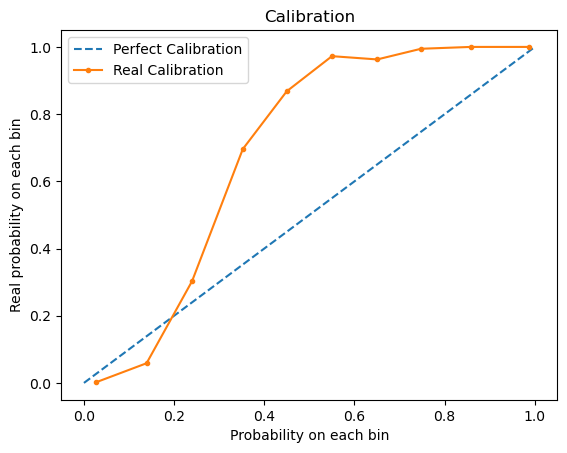

In [34]:
calibration(y_train, y_train_pred_prob)

**Val:**

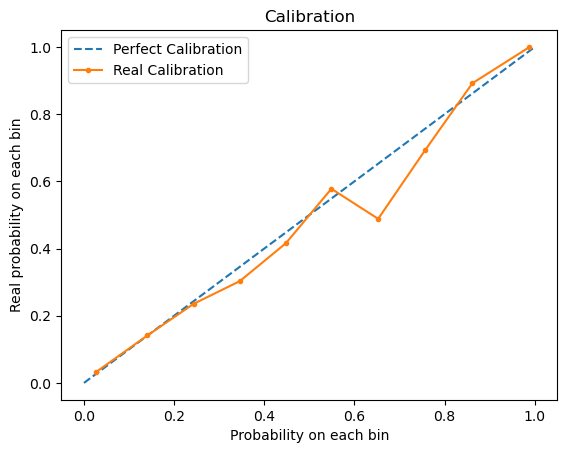

In [35]:
calibration(y_val, y_val_pred_prob)

**Test:**

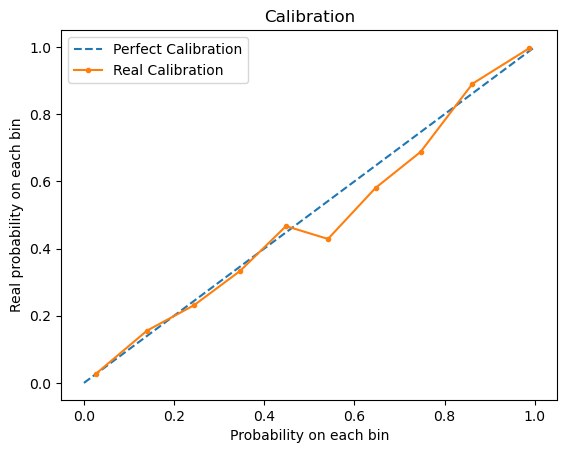

In [36]:
calibration(y_test, y_test_pred_prob)

### ix. Confidence Interval

When we have the probabilities $(MP)$ given by a model and the real probabilities $(RP)$ we can define the next random variable:

$ e = RP - MP $

When we have $n$ observations we have:

$ e_i = RP_i - MP_i \ \forall i \in \lbrace 1, ..., n \rbrace $

We can compute $ S $ and $ \bar{e} $ as follows:

$ \bar{e} = \frac{1}{n} \sum_{i=1}^n e_i $

$ S = \sqrt{\cfrac{1}{(n-1)} \cdot \sum_{i=1}^n (e_i - \bar{e})^2} $

Asumming $ e \sim Normal $ we can say that:

$ \bar{e} - S \cdot 1.96 + MP_i \leq RP_i \leq \bar{e} + S \cdot 1.96 + MP_i $     $ \forall i \in \lbrace 1, ..., n \rbrace$  with $ 95 \% $ of confidence.

And also:

$ \bar{e} - \cfrac{S}{\sqrt{n}} \cdot 1.96 + \bar{MP} \leq \bar{RP} \leq \bar{e} + \cfrac{S}{\sqrt{n}} \cdot 1.96 + \bar{MP} $  with $ 95 \% $ of confidence.

In [37]:
real_probs_val, model_probs_val = calibration_curve(y_val, y_val_pred_prob, n_bins = 100, normalize = True)

In [38]:
df_ci_val = pd.DataFrame(zip(model_probs_val, real_probs_val))
df_ci_val = df_ci_val.rename(columns = {0: 'model_prob', 1: 'real_prob'})
df_ci_val['error'] = df_ci_val['real_prob'] - df_ci_val['model_prob']

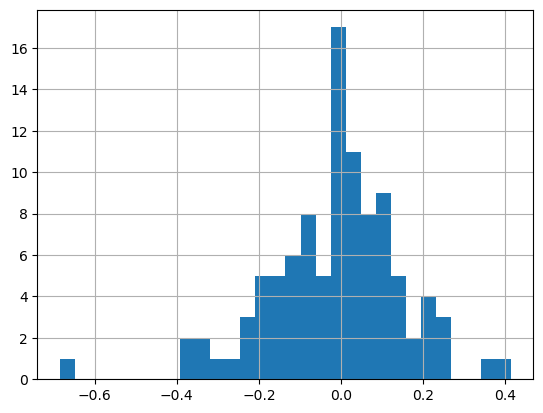

In [39]:
df_ci_val['error'].hist(bins = 30)
plt.show()

**Comments:** The distribution are very similar to a Normal.

In [40]:
bar_e = df_ci_val['error'].mean()
S = df_ci_val['error'].std()

In [41]:
round(bar_e*100, 2), round(S*100, 2)

(-1.57, 16.29)

### x. Patterns

**Loan Grade vs Loan Status**

In [42]:
X_test['predict'] = y_test_pred

In [43]:
round(X_test[X_test['loan_grade_A'] == 1]['predict'].mean()*100, 2)

8.6

In [44]:
round(X_test[X_test['loan_grade_B'] == 1]['predict'].mean()*100, 2)

16.5

In [45]:
round(X_test[X_test['loan_grade_C'] == 1]['predict'].mean()*100, 2)

22.53

In [46]:
round(X_test[X_test['loan_grade_D'] == 1]['predict'].mean()*100, 2)

64.79

In [47]:
round(X_test[X_test['loan_grade_E'] == 1]['predict'].mean()*100, 2)

74.42

In [48]:
round(X_test[X_test['loan_grade_F'] == 1]['predict'].mean()*100, 2)

72.5

In [49]:
round(X_test[X_test['loan_grade_G'] == 1]['predict'].mean()*100, 2)

100.0

In [50]:
X_test = X_test.drop(columns = ['predict'])

### xi. Feature importance

In [51]:
fi = pd.DataFrame(zip(clf.feature_names_in_, clf.feature_importances_))
fi = fi.rename(columns = {0: 'Variable', 1: 'Importance'})
fi['Importance'] = fi['Importance']*100

fi = fi.sort_values(by = ['Importance'], ascending = False)
fi = fi.reset_index()
fi = fi.drop(columns = ['index'])

In [52]:
fi

,Variable,Importance
0,person_home_ownership,19.416843
1,loan_grade_C,14.175413
2,loan_percent_income,11.366686
3,loan_grade_D,10.184950
4,loan_grade_A,6.624121
5,loan_intent,5.761088
6,loan_int_rate,5.275599
7,loan_grade_G,4.195548
8,person_income,3.813357
9,loan_grade_E,3.577051


### xii. Explainability

In [53]:
import shap

In [54]:
explainer = shap.TreeExplainer(clf)

In [55]:
shap_values = explainer.shap_values(X_test)

In [56]:
df_shap_values = pd.DataFrame(shap_values)
df_shap_values.columns = X_test.columns

**Importance Variable**

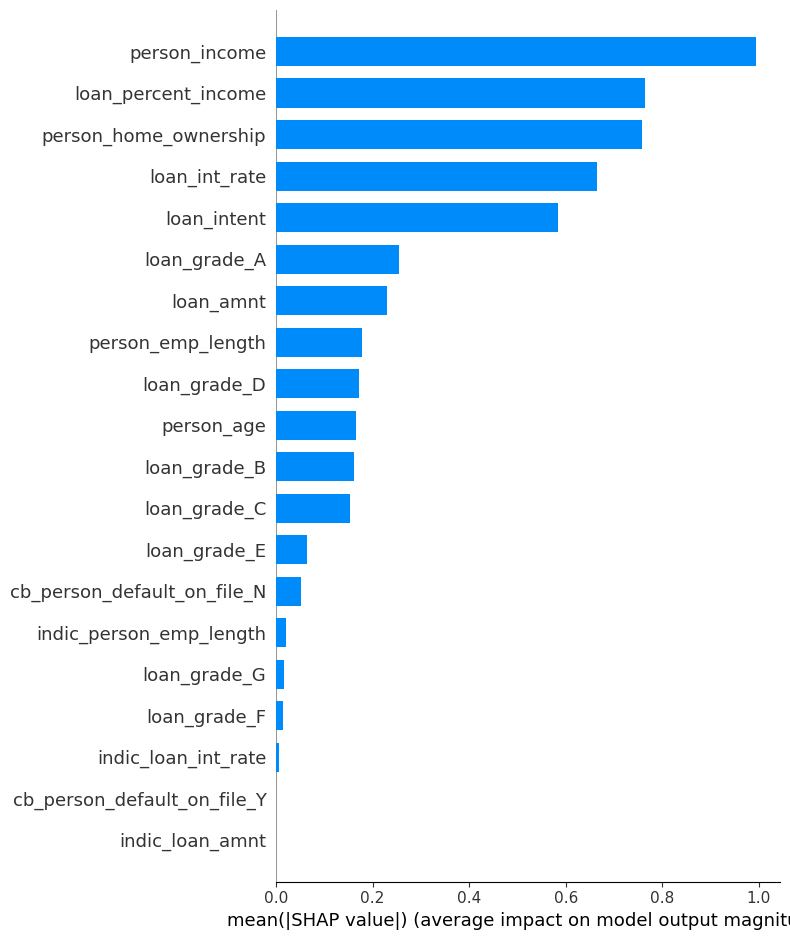

In [57]:
shap.summary_plot(shap_values, X_test, plot_type = "bar")

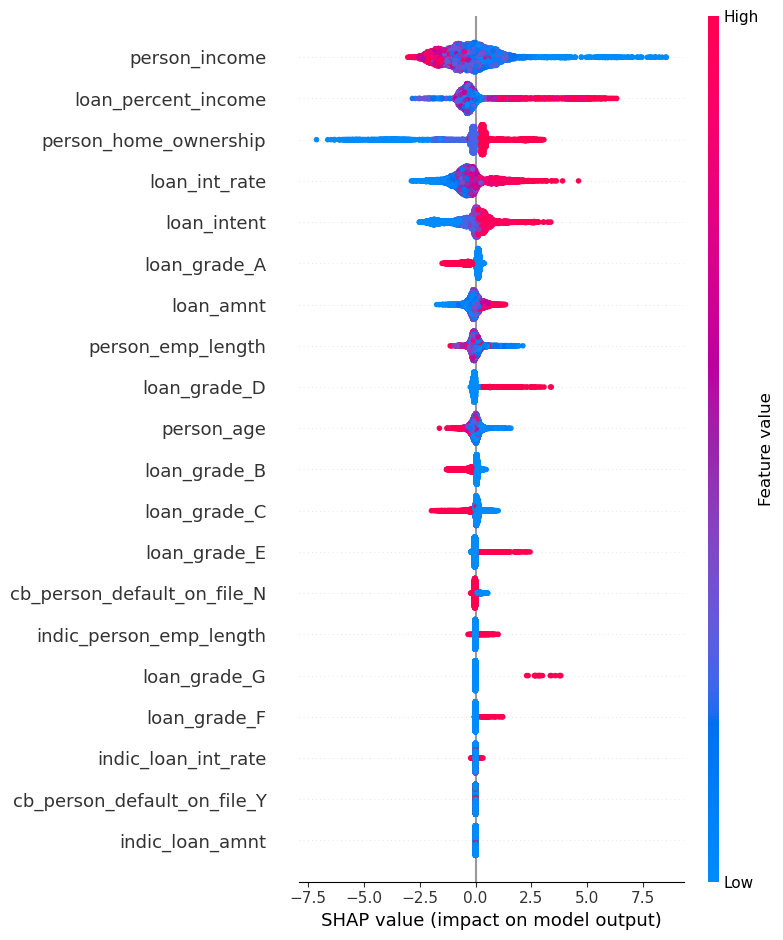

In [58]:
shap.summary_plot(shap_values, X_test)

In [59]:
df_shap_values['partial_sum_SHAP'] = df_shap_values.sum(axis = 1)

In [60]:
df_shap_values = df_shap_values[['partial_sum_SHAP']]

In [61]:
df_shap_values['prob_model'] = y_test_pred_prob

**Sum of SHAP Values**

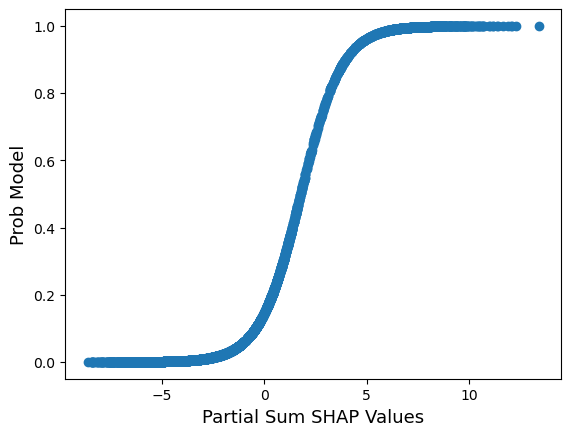

In [62]:
plt.scatter(df_shap_values['partial_sum_SHAP'], df_shap_values['prob_model'])
plt.xlabel('Partial Sum SHAP Values', fontsize = 13)
plt.ylabel('Prob Model', fontsize = 13)
plt.show()

**SHAP dependency**

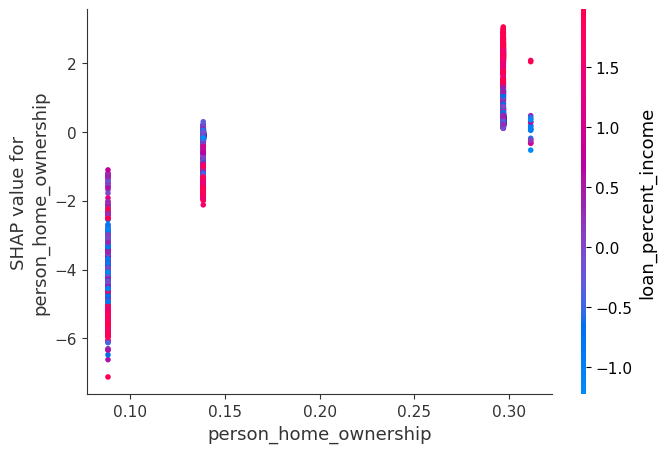

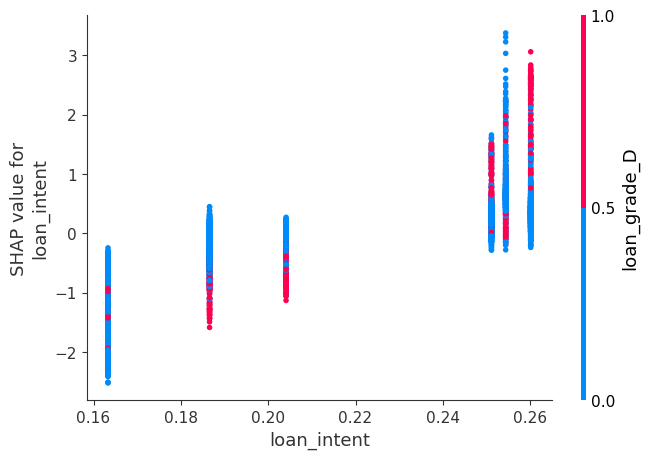

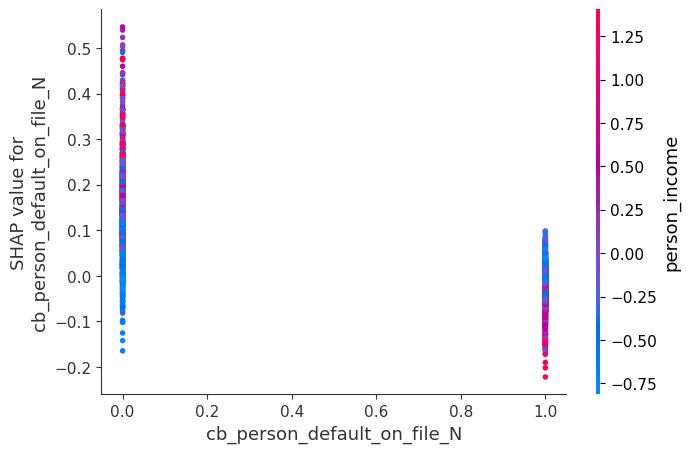

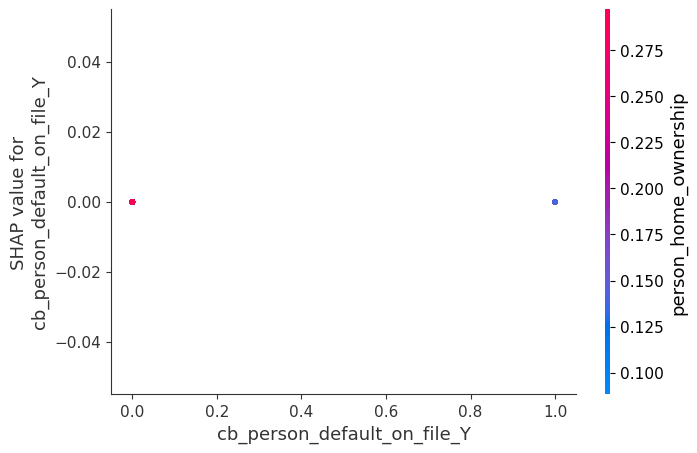

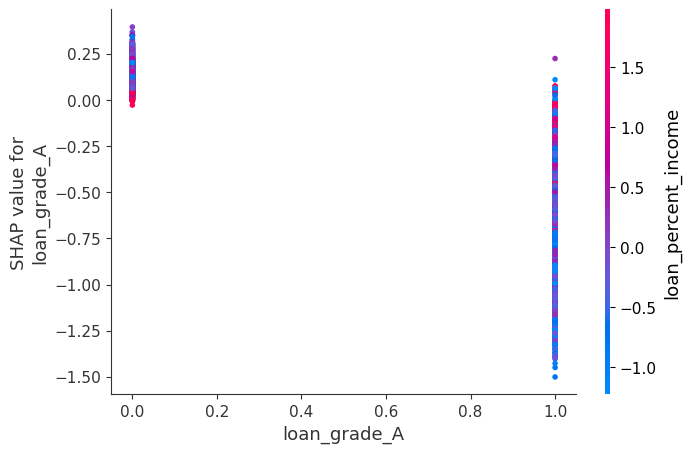

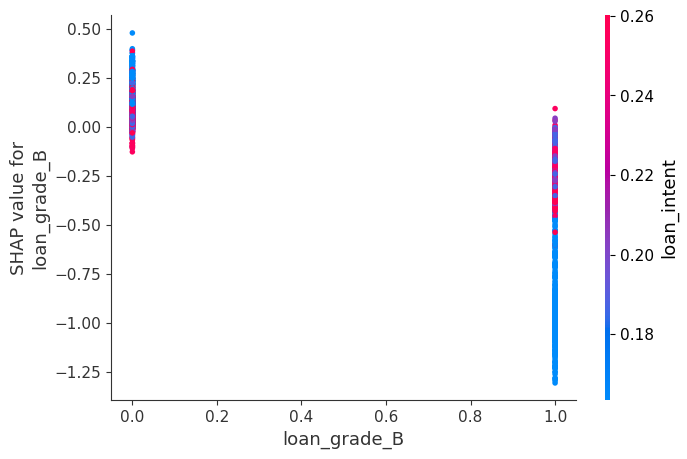

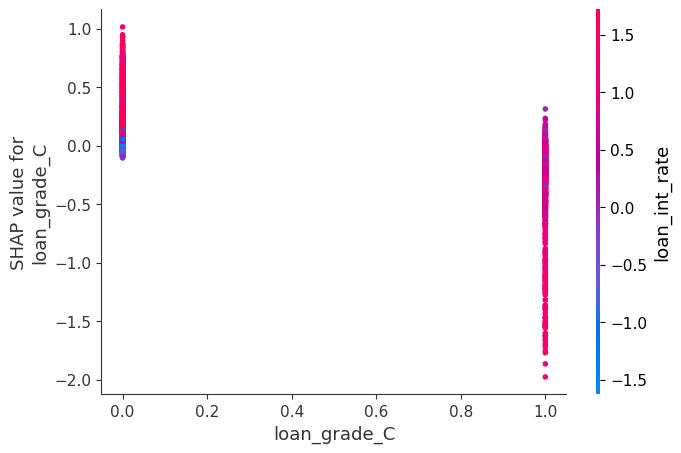

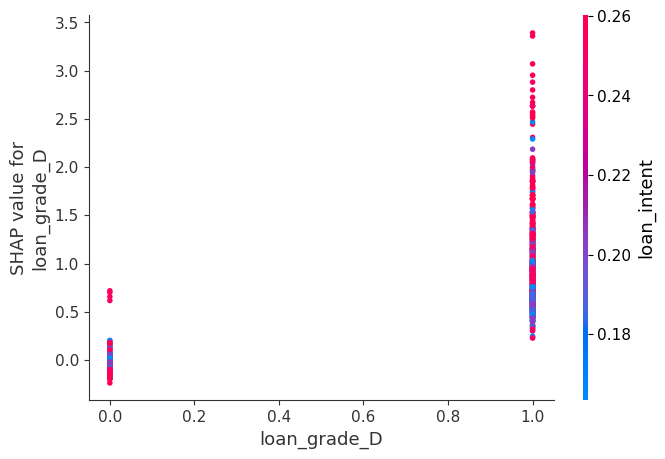

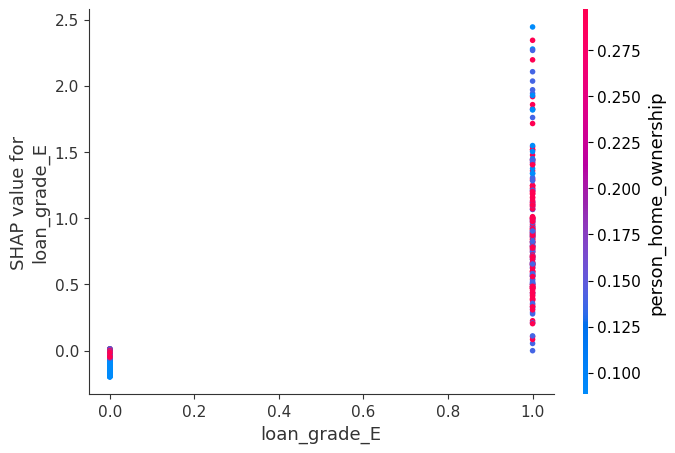

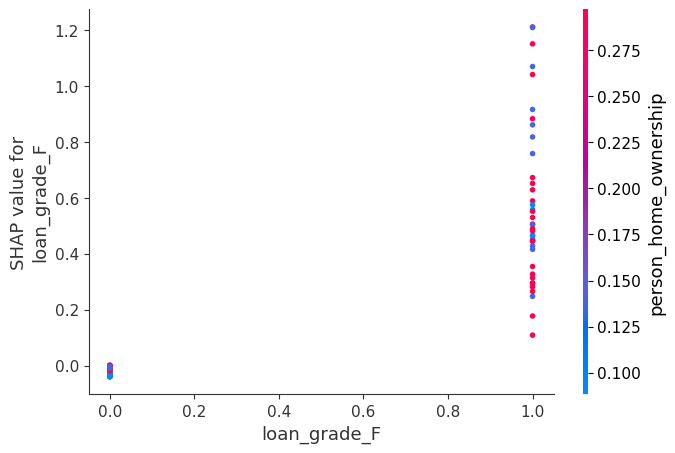

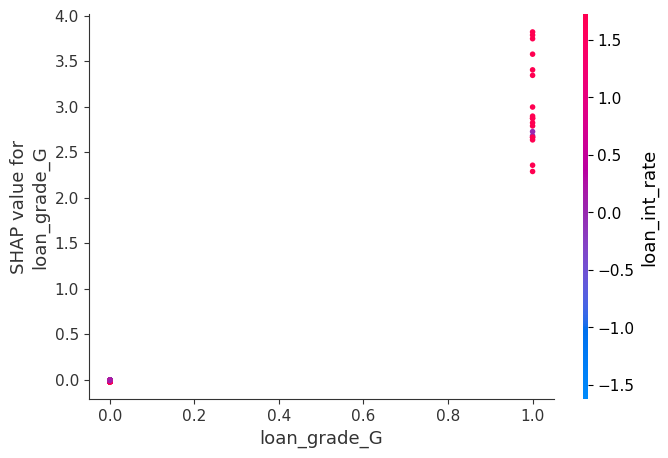

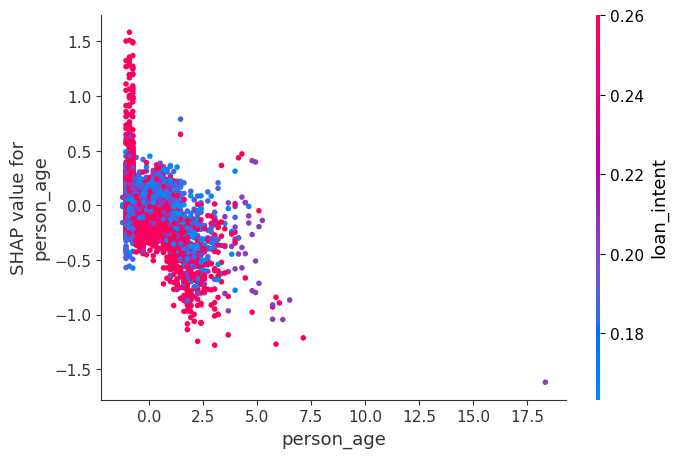

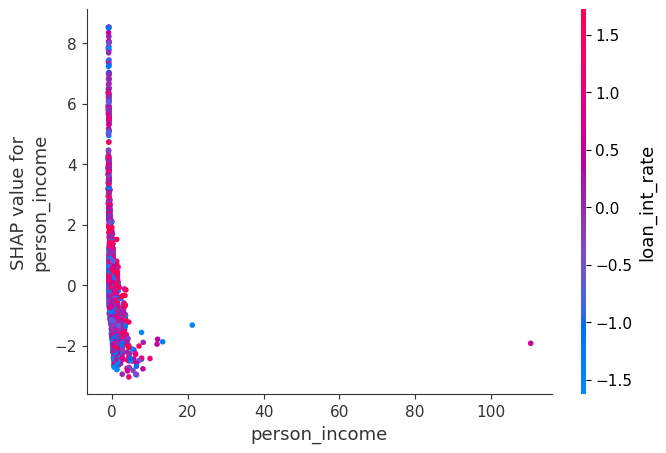

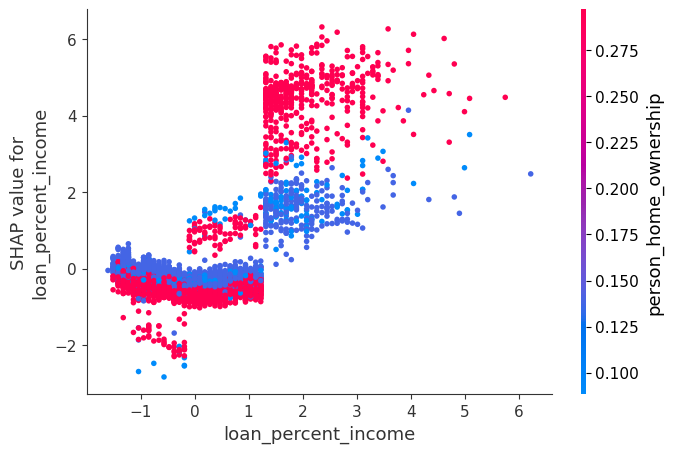

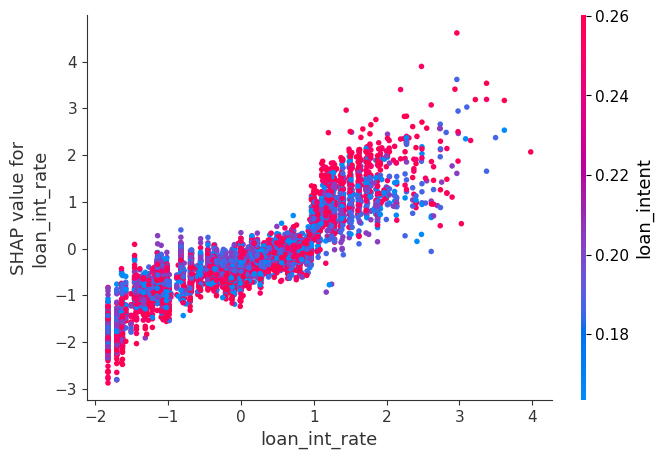

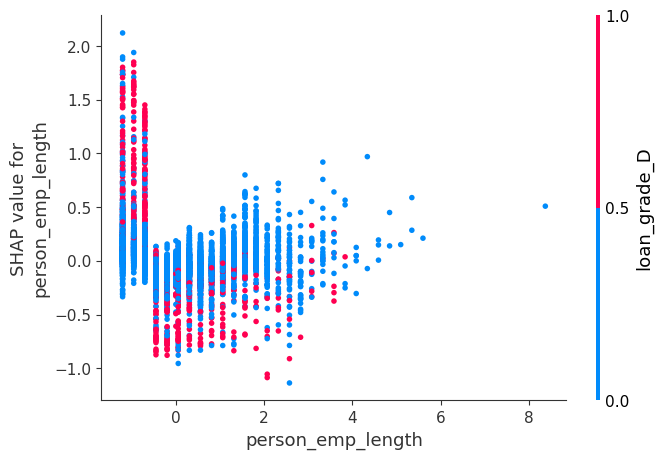

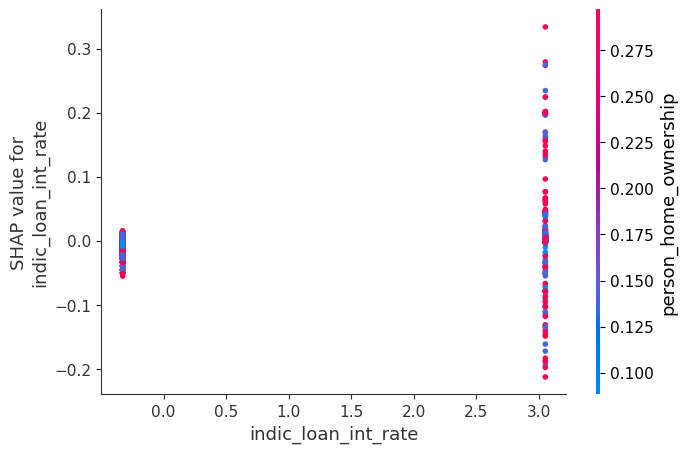

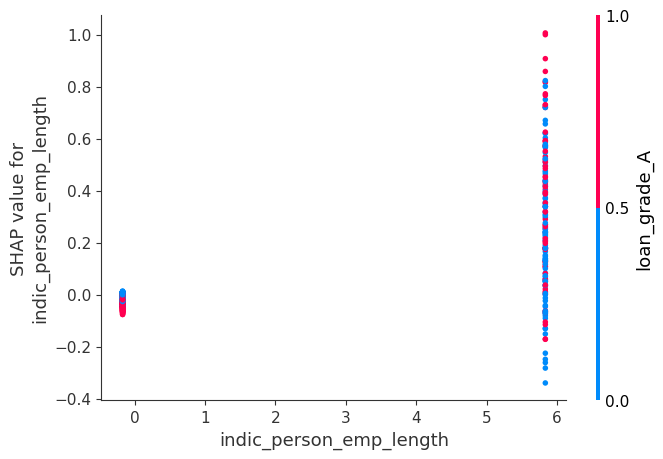

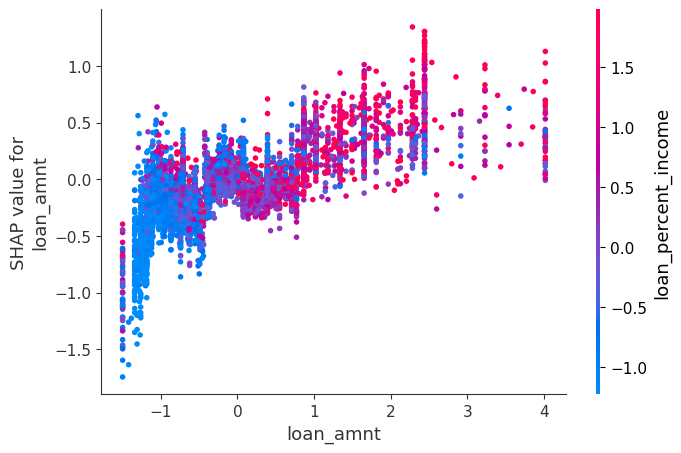

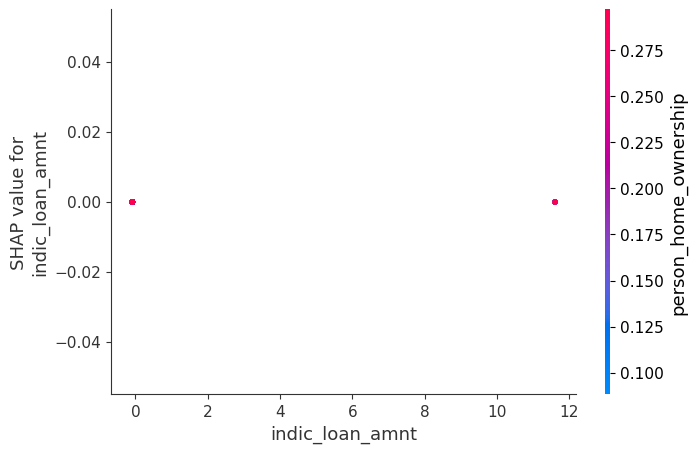

In [63]:
for name in X_test.columns:
    shap.dependence_plot(name, shap_values, X_test)

### Time of execution

In [64]:
end = time.time()

In [65]:
delta = (end - start)

hours = int(delta/3600)
mins = int((delta - hours*3600)/60)
segs = int(delta - hours*3600 - mins*60)
print(f'Execute this notebook take us {hours} hours, {mins} minutes and {segs} seconds.')

Execute this notebook take us 0 hours, 4 minutes and 56 seconds.
